### Network

#### Network
- Network => Graph
  - V/N - Nodes/Vertices
  - E - Edges
  - G = (V;E)
- Network can be represented using Adjancy Matrix
    - A(G) -> N X N Square Matrix
    - $a_{ij}$ = 1 if $\exists ~~ E: i \to j$ otherwise $0$

- Some Special Graphs:
  - Unidirectional Graph: $A = A^{T}$
  - Weighted Graph: Each edge has an assigned number, which is the element of the matrix

#### Measures of a Graph:  
- **Node Degree**/ Degree Availability,$k_\nu$ : Nuber of Edges of a Node
  - In degree: $k_\nu^{in} = \sum_{j = 1}^{N} a_{j\nu }$
  - In degree: $k_\nu^{out} = \sum_{j = 1}^{N} a_{\nu j}$
  - For Unidirectional Graph, $k_i^{in} = k_i^{out}$
- **Probability Distribution of k, P(k)**
- Link Density, $\rho$ : How densly network is connected  
  $\quad \rho = \frac{1}{N(N-1)} \sum_{ij}^N a_{ij}$
- **Clustering Coeff**, $C_\nu$ : Number of links b/w neighbours of a node  
  $\quad$ Are two Neighbours connected to each other  
  $\quad C_\nu = \frac{1}{k_\nu(k_\nu - 1)}\sum_{i,j}^N a_{\nu i}a_{ij} a_{j \nu}$
- Path Length, $L_{\nu}$  
  $\quad L_\nu = \frac{1}{n_{k(\nu)}} \sum_{i = 1}^{n_{k(\nu)}} l_{\nu i}$  
  Where  
  $l_{\nu i}$ : Minimum number of edges to traversed, $\nu$ to $i$  
  $\nu , i \in $ same Component (must be rechable)
- **Average Path Length**, $L = \frac{1}{N} \sum_{\nu = 1}^{N} L_\nu$
  
#### Random Graph(Erdős–Rényi (ER) model)  
Start with N unconnected Nodes -> Connect every pair with some probability $P$  
Degree Distribution -> Poissonian

#### Real Networks
Networks observed in real life - www, power grid, Co-authorship  
Most Real Graphs show power law in Degree Distribution  
$P(k) \sim k^{-\gamma} \implies$ Scale-free Network  
- Scale-free: Invariant under scaling; looks same upto constant factor;  
  no single degree(it spans over orders of magnitude)

#### Prefferential Attatchement Model  
- Explains why scaling occurs in random graphs
- Idea: New Nodes connect prefferentially to higly connected nodes
- Algorithm:
    - Small Number of nodes/vertices, $m_0$
    - New vertex with $m<m_0$ edges that links it to preexisting vertices
    - Prefferential Attatchement:
      Probability of a new vertex will connect to preisting vertex depends upon its degree.  
      $\quad P(k_i) = \frac{k_i}{\sum_j k_j}$
- After $t$ steps, we get random graph with $t+m_0$ vertices and $mt$ edges

#### Small World Graphs
- B/w regular and random networks
- Idea:
    - Start with regular graph, e.g., with a ring lattice with $n$ vertices and $k$ edges per vertex.
    - Rewire each edge at random with probability $p$
- Graph can be tuned between regularity$(p = 0)$ and disorder$(p = 1)$
- Analyse of characteristic path length, $L$ and clustering coefficient, $C_\nu$ as a function of $p$

#### Error and Attack Tolerance

In [1]:
import numpy as np
import scipy as sp
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib import gridspec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from ipywidgets.widgets import interactive,IntSlider
from collections import Counter

In [2]:
def clusteringCoeffNX(A):
    G = nx.from_numpy_array(A)
    return nx.clustering(G), nx.average_clustering(G)
    
def pathLengthDistributionNX(A):
    # Create graph from adjacency matrix
    G = nx.from_numpy_array(A)

    # Compute all-pairs shortest paths
    lengths = dict(nx.all_pairs_shortest_path_length(G))

    # Flatten into a list of distances (i < j to avoid double-counting)
    dists = []
    for u in lengths:
        for v in lengths[u]:
            if u < v:
                dists.append(lengths[u][v])

    # Distribution
    distribution = Counter(dists)

    # Average shortest path length
    avg_path_length = sum(dists) / len(dists)

    return distribution, avg_path_length

In [3]:
def removeUnidirectionalEdge(A,i,j):
    A[i,j] = 0
    A[j,i] = 0

def degree(A):
    #k = A.sum(axis = 1)
    k = np.sum(A,axis = 1)
    print("DEGREE",k)
    return k,np.mean(k)

def clusteringCoeff(A, directional = False):
    C_v = []
    N = len(A)
    if(directional):
        d = 1
    else:
        d = 2
    k,_ = degree(A)
    print(k)
    for node in range(N):
        if(k[node]<2):
            C_v.append(0)
            continue
        print(node,k[node])
        neighbours = np.where(A[node,:] == 1)[-1]

        C_v.append(
            np.sum(A[neighbours][:,neighbours])/(k[node]*(k[node]-1))
        )
        
    return C_v,np.mean(C_v)
    
def pathLength(A,i,j):
    
    l = 1
    search = np.where(A[i] == 1)[-1]
    
    for _ in range(len(A)):
        if(j in search):
            return l
        l += 1

        t = []
        for node in search:
            t.append(np.where(A[node] == 1)[-1])
        if(len(t) == 0):
            return 0
        search = np.concatenate(t).tolist()

    return 0
    
def pathLengthDistribution(A):
    '''
    Returns
    -------

    lengths : list of length Number of Nodes - 1
    Each position indicates the number of paths that length
    (Starting at length 1)

    average path length : float
    '''
    N = len(A)
    L_v,L_dist = [],[0]*(N)

    for i in range(N):
        l_vi = 0
        for j in range(N):
            l = pathLength(A,i,j)
            l_vi += l
            L_dist[l] += 1
        L_v.append(l_vi/(N-1))
    L_dist = np.array(L_dist)/2
    avg = L_dist[1:]*np.arange(1,N)
    avg = np.sum(avg)*2/(N*(N-1))
    
    return L_dist[1:],avg,L_v

In [4]:
def ringLattice(N = 250,k = 4,flag = False):
    '''
    k must be even
    '''
    #A = sp.sparse.csr_matrix((N,N))

    A = np.zeros((N,N),dtype = int)
    
    for i in range(1,k//2 + 1):
        A += np.eye(N,k=i,dtype=int)
        A += np.eye(N,k=-i,dtype=int)
        A += np.eye(N,k= N - i,dtype=int)
        A += np.eye(N,k=-N + i,dtype=int)
        
    return A

In [5]:
N,k = 6,4
A = ringLattice(N,k)
C_v,C = clusteringCoeff(A)
L_dist,avg_length,L_v = pathLengthDistribution(A)

#print("Adjency Matrix: ",A,sep = '\n')
print(f"N = {N}  k = {k}")
print("Clustering Coefficient: ",C_v,sep = '\n')
print("Mean Clustering Coefficient: ",C,sep = '\n')
print("Path Lengths: ",L_dist,sep = '\n')
print("Avg Path Length of Nodes: ",L_v,sep = '\n')
print("Mean Path Length: ",avg_length,sep = '\n')
print("----------------------------------------")
clusteringCoeffNX(A),pathLengthDistributionNX(A)

DEGREE [4 4 4 4 4 4]
[4 4 4 4 4 4]
0 4
1 4
2 4
3 4
4 4
5 4
N = 6  k = 4
Clustering Coefficient: 
[np.float64(0.6666666666666666), np.float64(0.6666666666666666), np.float64(0.6666666666666666), np.float64(0.6666666666666666), np.float64(0.6666666666666666), np.float64(0.6666666666666666)]
Mean Clustering Coefficient: 
0.6666666666666666
Path Lengths: 
[12.  6.  0.  0.  0.]
Avg Path Length of Nodes: 
[1.6, 1.6, 1.6, 1.6, 1.6, 1.6]
Mean Path Length: 
1.6
----------------------------------------


(({0: 0.6666666666666666,
   1: 0.6666666666666666,
   2: 0.6666666666666666,
   3: 0.6666666666666666,
   4: 0.6666666666666666,
   5: 0.6666666666666666},
  0.6666666666666666),
 (Counter({1: 12, 2: 3}), 1.2))

In [6]:
def plot_graph_properties(A):
    """
    Plots the graph, degree distribution, path length distribution, and clustering coefficient distribution,
    coloring nodes according to those properties, and comparing with NetworkX results.

    Parameters
    ----------
    adj : np.ndarray
        The adjacency matrix (should be square, unweighted, undirected).
    """
    # Ensure adjacency is numpy array and binary (0/1)
    #A = np.array(adj)
    N = len(A)

    # ========== COLORS AND GRAPH CONSTRUCTION ==========
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G, seed=42)  # for reproducibility

    #####deg,deg_avg = degree(A)
    k,k_avg = degree(A)
    
    # Path lengths: for each node, use mean path length to all others it can reach
    L_dist,avg_length,L_v = pathLengthDistribution(A)

    # Clustering coefficient (per node and average)
    C_v,C = clusteringCoeff(A)
    
    ####clust_avg = clust.mean()
    #print(k,k_avg)
    #print(L_dist,avg_length,L_v)
    print(C_v,C)

    # ========== PLOTTING ==========
    plt.ioff()
    fig = plt.figure(figsize=(8,16))
    spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig, height_ratios=[2, 1, 1, 1])

    # 1. Top: Graph (with degree colormap)
    ax0 = fig.add_subplot(spec[0, :])
    deg_norm = Normalize(vmin=k.min(), vmax=k.max())
    deg_cmap = plt.cm.viridis
    deg_colors = deg_cmap(deg_norm(k))
    nx.draw_networkx(G, pos=pos, ax=ax0, node_color=deg_colors, edge_color="gray", with_labels=True)
    ax0.set_title('Graph Colored by Node Degree')
    # Colorbar
    #sm = ScalarMappable(norm=deg_norm, cmap=deg_cmap)
    #cbar = plt.colorbar(sm, ax=ax0, orientation='horizontal', pad=0.01, fraction=0.04)
    #cbar.set_label('Degree')

    # 2. Degree Distribution
    ax1 = fig.add_subplot(spec[1, 0])
    vals, bins, patches = ax1.hist(k, bins=range(int(k.min()), int(k.max()) + 2), color="skyblue", edgecolor="black")
    ax1.axvline(k_avg, color='red', linestyle='--', label=f"Mean degree: {k_avg:.2f}")
    ax1.set_xlabel('Node Degree')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Degree Distribution')
    ax1.legend()

    # 2b. Graph colored by degree
    ax1b = fig.add_subplot(spec[1, 1])
    nx.draw_networkx(G, pos=pos, ax=ax1b, node_color=deg_colors, edge_color="gray", with_labels=True)
    ax1b.set_title('Nodes Colored by Degree')
    ax1b.axis('off')

    # 3. Path Length Distribution
    ax2 = fig.add_subplot(spec[2, 0])
    ax2.bar(range(1, len(L_dist) + 1), L_dist, color="lightgreen", edgecolor="black")
    ax2.axhline(avg_length, color='red', linestyle='--', label=f"Avg. Path Length: {avg_length:.2f}")
    ax2.set_xlabel('Path Length')
    ax2.set_ylabel('Count')
    ax2.set_title('Path Length Distribution')
    ax2.legend()

    # 3b. Graph colored by avg. path length to other nodes
    path_norm = Normalize(vmin=np.min(L_v), vmax=np.max(L_v))
    path_cmap = plt.cm.plasma
    path_colors = path_cmap(path_norm(L_v))
    ax2b = fig.add_subplot(spec[2, 1])
    nx.draw_networkx(G, pos=pos, ax=ax2b, node_color=path_colors, edge_color="gray", with_labels=True)
    ax2b.set_title('Nodes Colored by Mean Path Length')
    ax2b.axis('off')
    #sm2 = ScalarMappable(norm=path_norm, cmap=path_cmap)
    #cbar2 = plt.colorbar(sm2, ax=ax2b, orientation='horizontal', pad=0.01, fraction=0.04)
    #cbar2.set_label("Mean path length (from each node)")

    # 4. Clustering coefficient distribution
    ax3 = fig.add_subplot(spec[3, 0])
    ax3.hist(C_v, bins=np.linspace(0,1,11), color="orchid", edgecolor="black")
    ax3.axvline(C, color='red', linestyle='--', label=f"Mean: {C:.2f}")
    ax3.set_xlabel('Clustering Coefficient')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Clustering Coefficient Distribution')
    ax3.legend()

    # 4b. Graph colored by clustering coefficient
    clust_norm = Normalize(vmin=np.min(C_v), vmax=np.max(C_v))
    clust_cmap = plt.cm.viridis
    clust_colors = clust_cmap(clust_norm(C_v))
    ax3b = fig.add_subplot(spec[3, 1])
    nx.draw_networkx(G, pos=pos, ax=ax3b, node_color=clust_colors, edge_color="gray", with_labels=True)
    ax3b.set_title('Nodes Colored by Clustering Coefficient')
    ax3b.axis('off')
    #sm3 = ScalarMappable(norm=clust_norm, cmap=clust_cmap)
    #cbar3 = plt.colorbar(sm3, ax=ax3b, orientation='horizontal', pad=0.01, fraction=0.04)
    #cbar3.set_label("Clustering coefficient")

    for ax in [ax1, ax2, ax3]:
        ax.grid(True, linestyle=':', alpha=0.5)

    # ========== INTERACTIVITY ==========
    plt.tight_layout()
    plt.show()

    # ========== NETWORKX VERIFICATION ==========

    print("----- NetworkX Verification -----")

    deg_nx = dict(G.degree())
    degrees_nx = np.array(list(deg_nx.values()))
    print(f"- Degree mean (networkx): {degrees_nx.mean():.3f} | Yours: {k_avg:.3f}")

    cc_nx = list(nx.clustering(G).values())
    print(f"- Clustering mean (networkx): {np.mean(cc_nx):.3f} | Yours: {C:.3f}")

    pl_nx = dict(nx.all_pairs_shortest_path_length(G))
    node_nxavpath = []
    for u in range(N):
        npaths = [l for v, l in pl_nx[u].items() if u != v]
        node_nxavpath.append(np.mean(npaths) if npaths else 0)
    print(f"- Avg. path length (networkx): {np.mean(node_nxavpath):.3f} | Yours: {avg_length:.3f}")

    # Node-by-node checks
    print("- Degree per node equal to NetworkX:", np.allclose(k, degrees_nx))
    print("- Clustering per node ~ NetworkX:", np.allclose(C_v, cc_nx, rtol=1e-2, atol=1e-2))
    print("- Mean path length per node ~ NetworkX:", np.allclose(L_v, node_nxavpath, rtol=1e-2, atol=1e-2))

# Optional: if you want to use interactively with Jupyter Lab for zoom/pan:
# %matplotlib widget
# plot_graph_properties(A)

DEGREE [4 4 4 4 4 4 4 4 4 4]
DEGREE [4 4 4 4 4 4 4 4 4 4]
[4 4 4 4 4 4 4 4 4 4]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.5)] 0.5


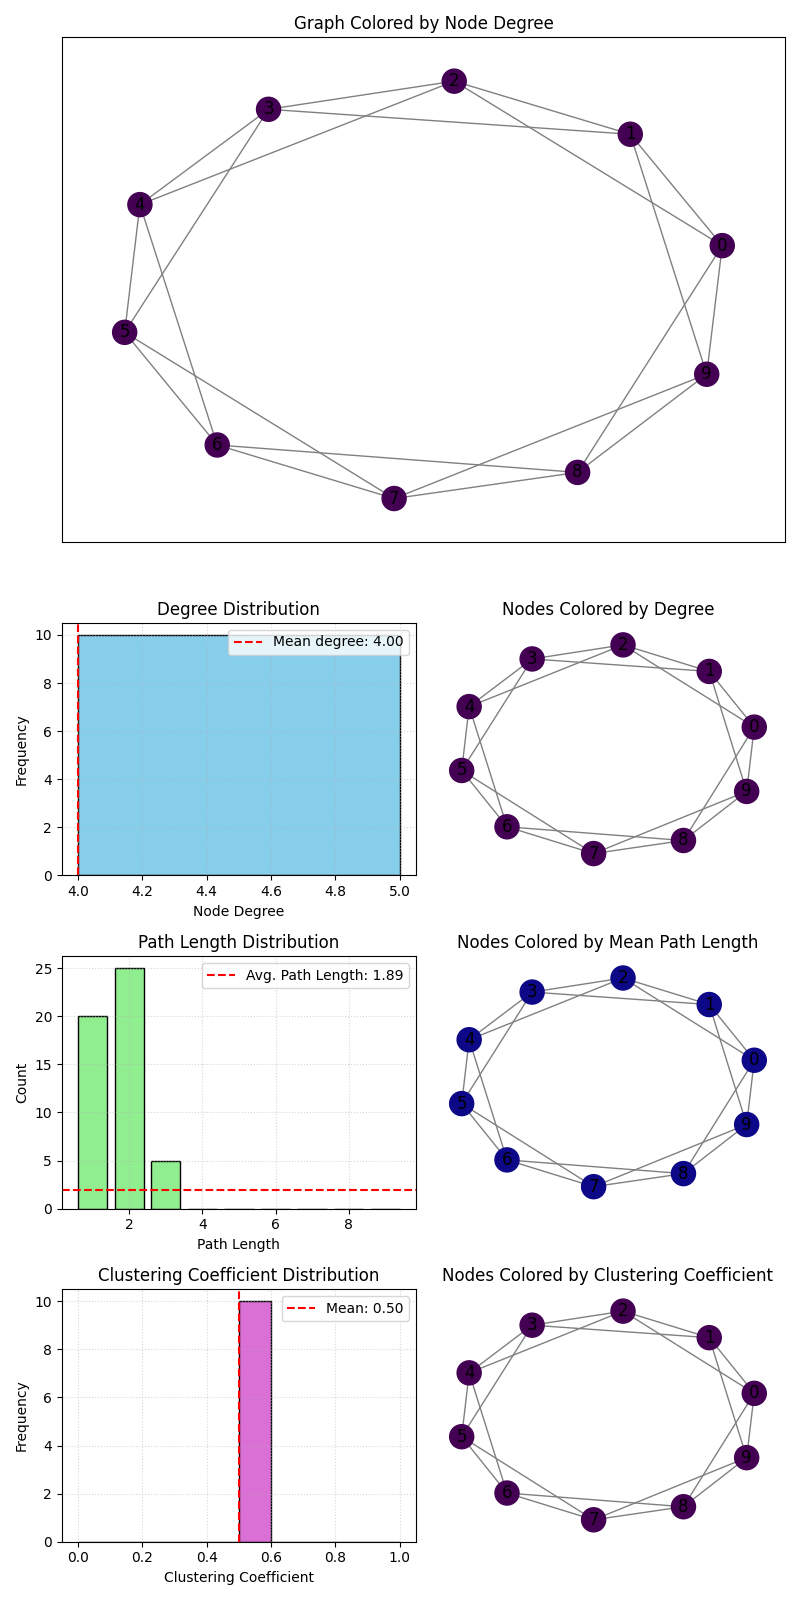

----- NetworkX Verification -----
- Degree mean (networkx): 4.000 | Yours: 4.000
- Clustering mean (networkx): 0.500 | Yours: 0.500
- Avg. path length (networkx): 1.667 | Yours: 1.889
- Degree per node equal to NetworkX: True
- Clustering per node ~ NetworkX: True
- Mean path length per node ~ NetworkX: False


In [7]:
%matplotlib widget
N,k = 10,4
A = ringLattice(N,k)
plot_graph_properties(A)

In [8]:
def erdosRenyi(N = 250,p = 0.1,rng = np.random.default_rng(123)):
    A = np.triu(rng.random((N,N)))
    A = A + A.T
    A[np.arange(N),np.arange(N)] = 0
    A = np.where(A>=p,1,0)
    
    return A
    

In [9]:
B = erdosRenyi(5,p = 0.5)
B

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [0, 1, 1, 1, 0]])

DEGREE [0 2 1 2 3]
DEGREE [0 2 1 2 3]
[0 2 1 2 3]
1 2
3 2
4 3
[0, np.float64(1.0), 0, np.float64(1.0), np.float64(0.3333333333333333)] 0.4666666666666667


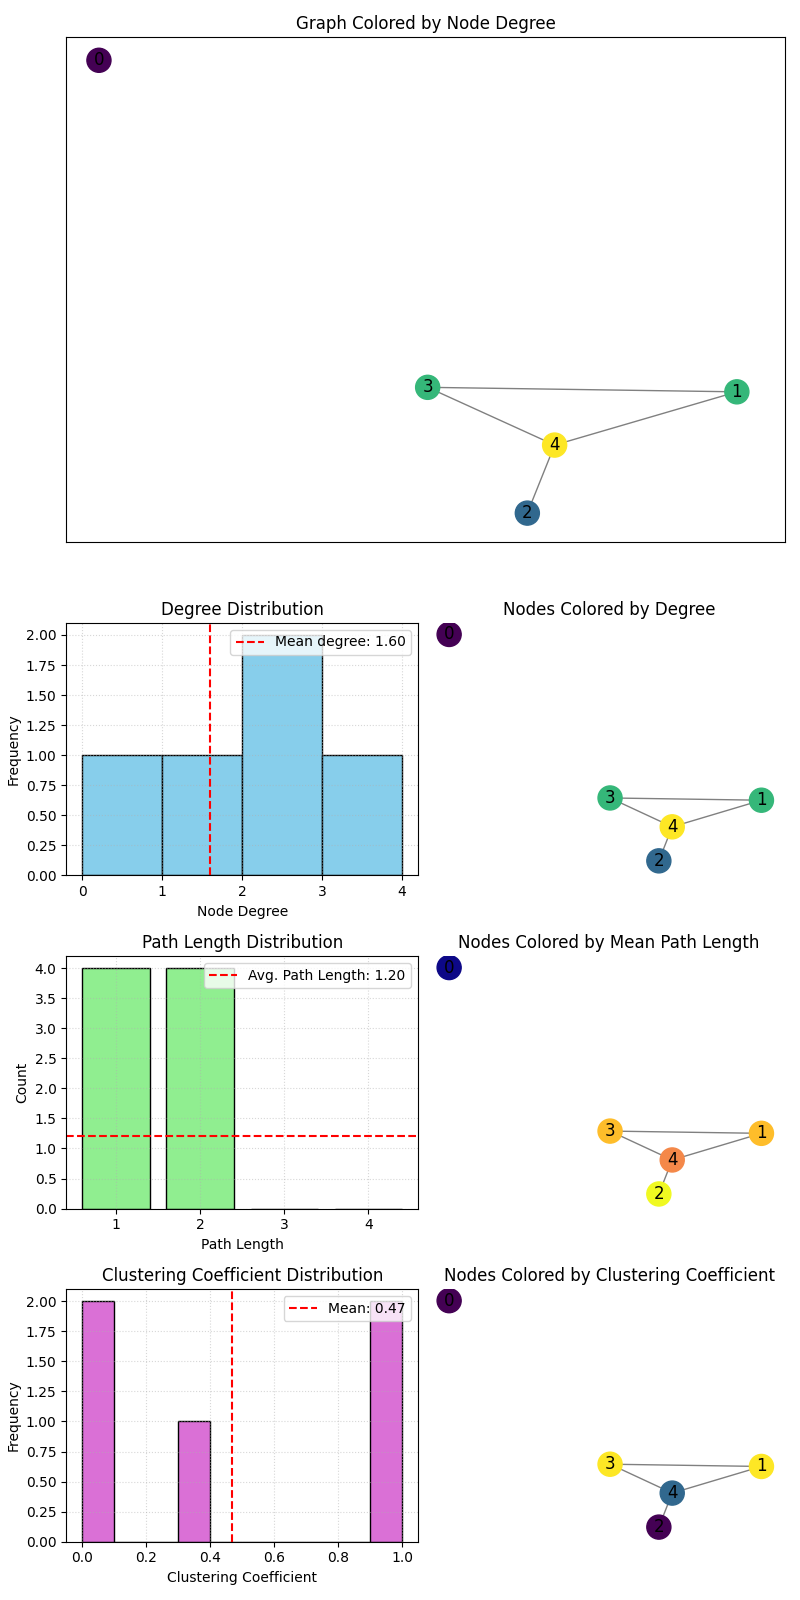

----- NetworkX Verification -----
- Degree mean (networkx): 1.600 | Yours: 1.600
- Clustering mean (networkx): 0.467 | Yours: 0.467
- Avg. path length (networkx): 1.067 | Yours: 1.200
- Degree per node equal to NetworkX: True
- Clustering per node ~ NetworkX: True
- Mean path length per node ~ NetworkX: False


In [10]:
plot_graph_properties(B)

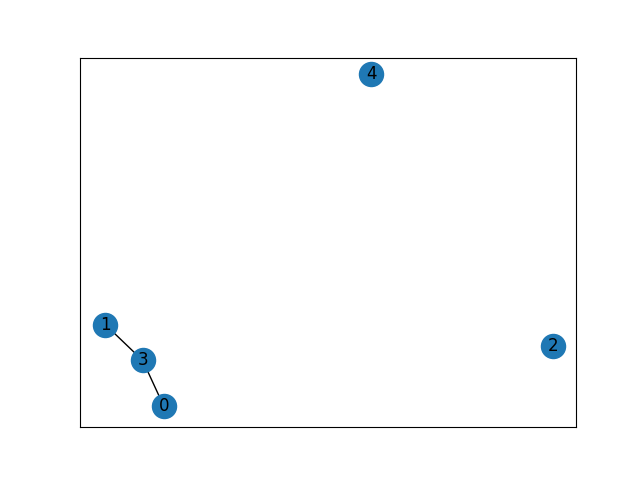

DEGREE [1 1 0 2 0]
[1 1 0 2 0]
3 2
N = 5  p = 0.8
Clustering Coefficient: 
[0, 0, 0, np.float64(0.0), 0]
Mean Clustering Coefficient: 
0.0
Path Lengths: 
[2.  2.5 0.  0. ]
Avg Path Length of Nodes: 
[1.25, 1.25, 0.0, 1.0, 0.0]
Mean Path Length: 
0.7
----------------------------------------
({0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5, 6: 0.5, 7: 0.5, 8: 0.5, 9: 0.5}, 0.5) (Counter({1: 20, 2: 20, 3: 5}), 1.6666666666666667)


In [11]:
B = erdosRenyi(5,p = 0.8)
G2 = nx.from_numpy_array(B)
nx.draw_networkx(G2,pos = nx.spring_layout(G2))
plt.show()

C_v,C = clusteringCoeff(B)
L_dist,avg_length,L_v = pathLengthDistribution(B)

#print("Adjency Matrix: ",A,sep = '\n')
print(f"N = {len(B)}  p = {0.8}")
print("Clustering Coefficient: ",C_v,sep = '\n')
print("Mean Clustering Coefficient: ",C,sep = '\n')
print("Path Lengths: ",L_dist,sep = '\n')
print("Avg Path Length of Nodes: ",L_v,sep = '\n')
print("Mean Path Length: ",avg_length,sep = '\n')
print("----------------------------------------")
print(clusteringCoeffNX(A),pathLengthDistributionNX(A))